# Naive UDD

In [108]:
import numpy as np
import math
from qiskit.pulse import Schedule, Play, DriveChannel, SamplePulse, ConstantPulse, Delay
from qiskit.pulse import InstructionScheduleMap
from qiskit.visualization import plot_histogram
from qiskit.test.mock import FakeAlmaden
from qiskit import IBMQ, execute
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule

In [2]:
# Build noise model from backend properties
provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_vigo')
backend = provider.get_backend('ibmq_armonk')

In [34]:
# build a circuit to get pulse schedule with X gate
circ = QuantumCircuit(1, 1)
circ.x(0)
#circ.measure(0, 0)
transpiled_circ = transpile(circ, backend)
Xsch = build_schedule(transpiled_circ, backend)
transpiled_circ.draw()

┌─────────────┐
q_0: ┤ U3(pi,0,pi) ├
     └─────────────┘
c_0: ═══════════════

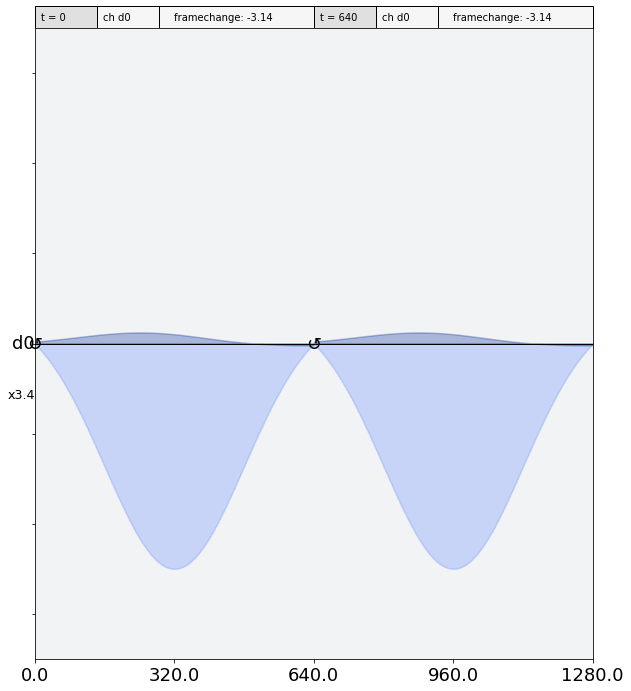

In [35]:
Xsch.draw()

In [36]:
# this defines the minimum time in UDD sequence
t1 = Xsch.duration
print("X Gate application time is: {}ns".format(t1))

X Gate application time is: 1280ns


In [73]:
circ = QuantumCircuit(1, 1)
circ.h(0)
transpiled_circ = transpile(circ, backend)
hadsch = build_schedule(transpiled_circ, backend)

circ = QuantumCircuit(1, 1)
circ.measure(0, 0)
transpiled_circ = transpile(circ, backend)
measch = build_schedule(transpiled_circ, backend)

In [114]:
def sj(j, n=3, t1=1280):
    """
    Normalized pulse interval spacing for UDD.
    """
    arg1 = ((2*j - 1)*np.pi) / (2*n + 2)
    arg2 = np.pi / (2*n + 2)
    
    return np.sin(arg1) / np.sin(arg2)

def pstimes(n, t0=0, t1=1280):
    """
    Genertes list of times to start pulses given a desired UDD decoupling time and minimum gate spacing.
    Time corresponds to time to schedule for pulse to END at necessary UDD application time.
    """
    if (n % 2 == 0):
        jmax = n
    else:
        jmax = n + 1
    
    tlist = [t0]
    ctime = t1
    
    for j in range(2, jmax+1):
        t = (sj(j) * t1) + ctime - (t1 + t0)
        tlist.append(t)
        ctime += t
        
    return tlist
    
def udd(n, Xsch, sched, backend=provider.get_backend('ibmq_armonk')):
    t0 = sched.duration
    t1 = Xsch.duration
    times = pstimes(n, t0, t1)
    
    # add first X pulse at beginning
    sched += Xsch
    prevt = times.pop(0)
    
    # iteratie over remaining times and add appropriate delays beteween pulses
    for t in times:
        t = math.ceil(t)
        sched += Delay(t - prevt, DriveChannel(0))
        sched += Xsch
        prevt = t
        
    return sched

In [100]:
uddsch = Schedule(name="UDD")
idsch = Schedule(name="Id")

uddsch = udd(3, Xsch, Schedule(name="UDD"))
idsch = Schedule(name="Id")
# add delay for length uddsch to identity
idsch += Delay(uddsch.duration, DriveChannel(0))

# add measurements
uddsch += measch.shift(uddsch.duration)
idsch += measch.shift(idsch.duration)

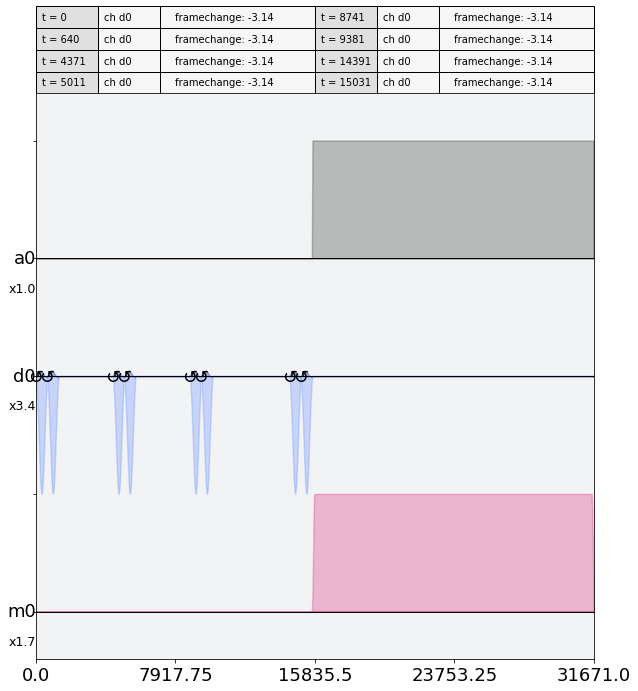

In [101]:
uddsch.draw()

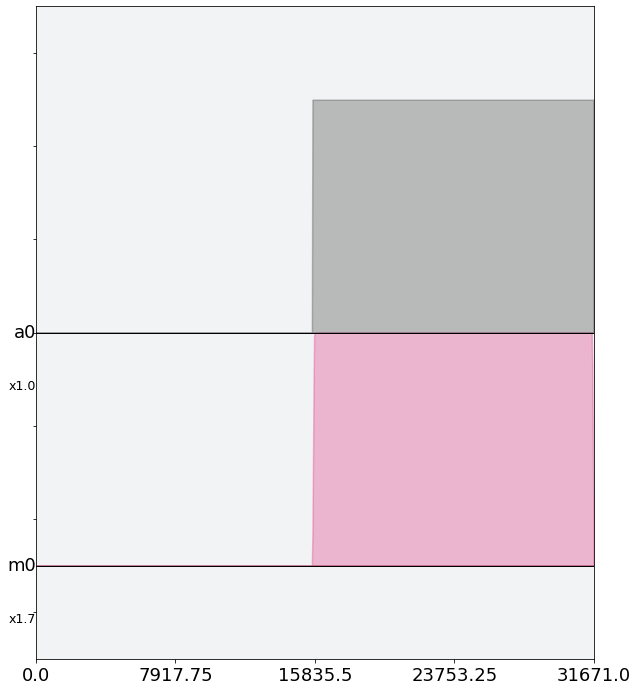

In [102]:
idsch.draw()

In [103]:
backend = IBMQ.load_account().get_backend(open_pulse=True)
job = execute(idsch, backend)
idresult = job.result()

job2 = execute(uddsch, backend)
uddresult = job2.result()

ibmqfactory.load_account:WARNING:2020-05-01 12:45:09,301: Credentials are already in use. The existing account in the session will be replaced.
/Users/worknic/opt/anaconda3/envs/test/lib/python3.8/site-packages/qiskit/compiler/transpile.py:174: UserWarning: Transpiling schedules is not supported yet.
  warnings.warn("Transpiling schedules is not supported yet.", UserWarning)
/Users/worknic/opt/anaconda3/envs/test/lib/python3.8/site-packages/qiskit/compiler/transpile.py:174: UserWarning: Transpiling schedules is not supported yet.
  warnings.warn("Transpiling schedules is not supported yet.", UserWarning)


In [105]:
idresult

Result(backend_name='ibmq_armonk', backend_version='1.1.0', date=datetime.datetime(2020, 5, 1, 19, 45, 28, tzinfo=datetime.timezone.utc), execution_id='4a349cb0-8be4-11ea-a097-ac1f6bb56700', header=Obj(backend_name='ibmq_armonk', backend_version='1.1.0'), job_id='5eac7c492451380011934860', qobj_id='78245992-11d4-4405-9006-2ee73b1a58ae', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=966, 0x1=58)), header=Obj(memory_slots=1, name='Id'), meas_level=2, memory=False, shots=1024, success=True)], status='Successful completion', success=True, time_taken=9.626321792602539)

In [106]:
uddresult

Result(backend_name='ibmq_armonk', backend_version='1.1.0', date=datetime.datetime(2020, 5, 1, 19, 46, 37, tzinfo=datetime.timezone.utc), execution_id='734ffc52-8be4-11ea-9369-ac1f6bb56700', header=Obj(backend_name='ibmq_armonk', backend_version='1.1.0'), job_id='5eac7c6bb0b7000011ce9cba', qobj_id='e252fcf5-623c-4099-b1ab-a3ed63c5ab5f', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=964, 0x1=60)), header=Obj(memory_slots=1, name='UDD'), meas_level=2, memory=False, shots=1024, success=True)], status='Successful completion', success=True, time_taken=9.436301946640015)

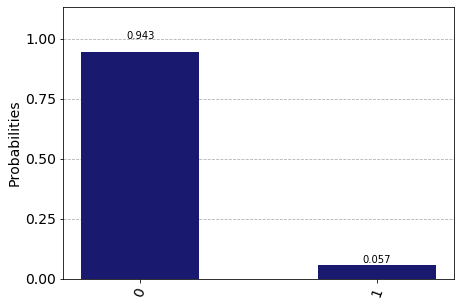

In [110]:
plot_histogram(idresult.get_counts(), color='midnightblue')

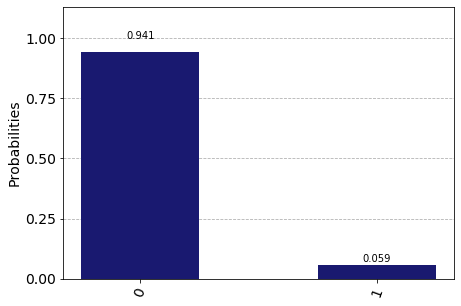

In [113]:
plot_histogram(uddresult.get_counts(), color='midnightblue')

## Trying same thing with hadamard state prep

In [125]:
def sj(j, n=3, t1=1280):
    """
    Normalized pulse interval spacing for UDD.
    """
    arg1 = ((2*j - 1)*np.pi) / (2*n + 2)
    arg2 = np.pi / (2*n + 2)
    
    return np.sin(arg1) / np.sin(arg2)

def pstimes(n, t0=0, t1=1280):
    """
    Genertes list of times to start pulses given a desired UDD decoupling time and minimum gate spacing.
    Time corresponds to time to schedule for pulse to END at necessary UDD application time.
    """
    if (n % 2 == 0):
        jmax = n
    else:
        jmax = n + 1
    
    tlist = [t0]
    ctime = t1
    
    for j in range(2, jmax+1):
        t = (sj(j) * t1) + ctime - (t1 + t0)
        tlist.append(t)
        ctime += t
        
    return tlist
    
def udd(n, Xsch, sched, backend=provider.get_backend('ibmq_armonk')):
    sched += hadsch
    t0 = sched.duration
    t1 = Xsch.duration
    times = pstimes(n, t0, t1)
    
    # add first X pulse at beginning
    sched += Xsch
    prevt = times.pop(0)
    
    # iteratie over remaining times and add appropriate delays beteween pulses
    for t in times:
        t = math.ceil(t)
        sched += Delay(t - prevt, DriveChannel(0))
        sched += Xsch
        prevt = t
        
    return sched

In [138]:
[sj(1), sj(2), sj(3), sj(4)]

[1.0, 2.414213562373095, 2.414213562373095, 1.0000000000000002]

In [136]:
pstimes(3)

[0, 3090.1933598375617, 6180.3867196751235, 10550.580079512685]

In [128]:
# init schedules and add hadamard
uddsch = Schedule(name="UDD")
idsch = Schedule(name="Id")
idsch += hadsch

# add on udd sequence/ identity of equal length
uddsch = udd(3, Xsch, Schedule(name="UDD"))
# add delay for length uddsch to identity
idsch += Delay(uddsch.duration - hadsch.duration, DriveChannel(0))

# decode and then measure
uddsch += hadsch
idsch += hadsch
uddsch += measch.shift(uddsch.duration)
idsch += measch.shift(idsch.duration)

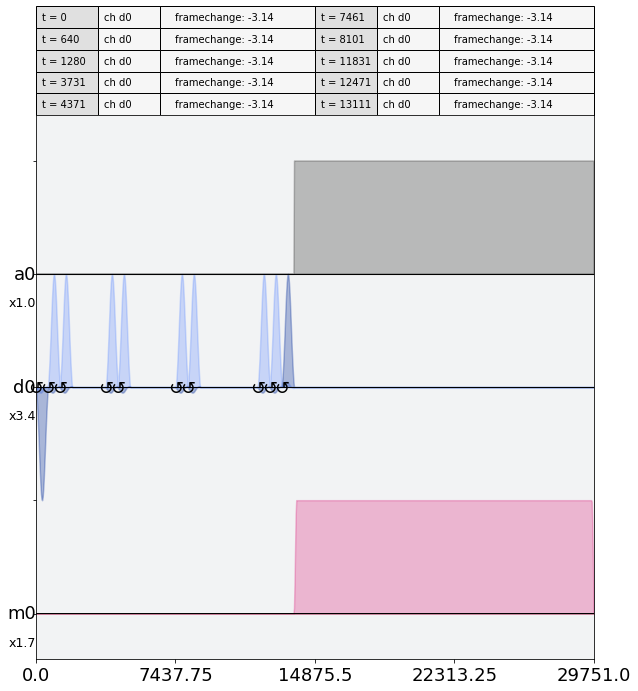

In [131]:
uddsch.draw()

In [132]:
backend = IBMQ.load_account().get_backend(open_pulse=True)
job = execute(idsch, backend)
idresult2 = job.result()

job2 = execute(uddsch, backend)
uddresult2 = job2.result()

ibmqfactory.load_account:WARNING:2020-05-01 13:10:13,082: Credentials are already in use. The existing account in the session will be replaced.
/Users/worknic/opt/anaconda3/envs/test/lib/python3.8/site-packages/qiskit/compiler/transpile.py:174: UserWarning: Transpiling schedules is not supported yet.
  warnings.warn("Transpiling schedules is not supported yet.", UserWarning)
/Users/worknic/opt/anaconda3/envs/test/lib/python3.8/site-packages/qiskit/compiler/transpile.py:174: UserWarning: Transpiling schedules is not supported yet.
  warnings.warn("Transpiling schedules is not supported yet.", UserWarning)


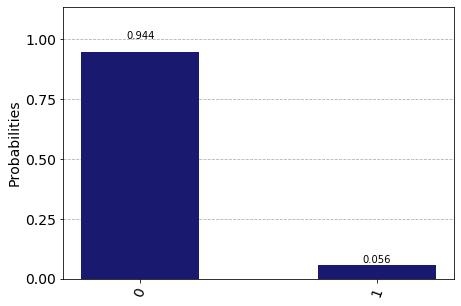

In [133]:
plot_histogram(idresult2.get_counts(), color='midnightblue')

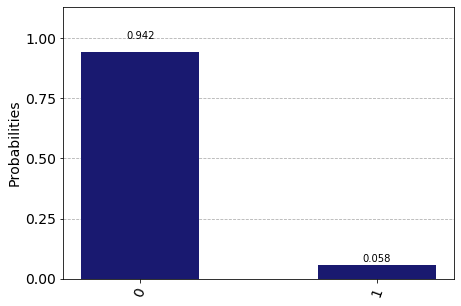

In [134]:
plot_histogram(uddresult2.get_counts(), color='midnightblue')